# MNIST卷积神经网络
这个案例中使用的是卷积神经网络进行MNIST识别。（输入图片保持28×28）
* 模型1：来自keras案例，2个卷积层+1个FC+softmax 参数很多，而且弄了dropout什么的，0.99
* 模型2：来自paddle案例，2个卷积（各自带maxpool），0.9904 层次上减少了很多，差距不大。


In [49]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from keras.utils import np_utils
from PIL import Image

In [15]:
batch_size = 128
num_classes = 10
epochs = 12
# 输入图像尺寸
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [35]:
#为何必须是三维的？？2维不行吗？
def loaddataMnist():
    f = np.load('./mnist.npz')
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    x_train/=255
    x_test/=255
    y_train = np_utils.to_categorical(y_train,num_classes)
    y_test = np_utils.to_categorical(y_test,num_classes)
    return (x_train,y_train),(x_test,y_test) 

In [36]:

# 数据，分为训练集和测试集
(x_train, y_train), (x_test, y_test) = loaddataMnist()

In [37]:
y_train.shape

(60000, 10)

In [38]:
def MnistConvModel(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    return model

In [39]:
# 一个
model = MnistConvModel(input_shape)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________

In [41]:
 history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 101s 2ms/step - loss: 0.3223 - acc: 0.9013 - val_loss: 0.0763 - val_acc: 0.9780
Epoch 2/12
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0997 - acc: 0.9711 - val_loss: 0.0565 - val_acc: 0.9826
Epoch 3/12
48000/48000 [==============================] - 101s 2ms/step - loss: 0.0748 - acc: 0.9772 - val_loss: 0.0456 - val_acc: 0.9873
Epoch 4/12
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0607 - acc: 0.9820 - val_loss: 0.0445 - val_acc: 0.9867
Epoch 5/12
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0513 - acc: 0.9850 - val_loss: 0.0421 - val_acc: 0.9886
Epoch 6/12
48000/48000 [==============================] - 99s 2ms/step - loss: 0.0440 - acc: 0.9867 - val_loss: 0.0414 - val_acc: 0.9884
Epoch 7/12
48000/48000 [==============================] - 97s 2ms/step - loss:

In [45]:
score=model.evaluate(x_test,y_test)
print("test score",score[0])
print("test accuracy",score[1])

10000/10000 [==============================] - 5s 534us/step
test score 0.028613312207178387
test accuracy 0.9902


In [61]:
from keras.preprocessing import image
from matplotlib.pyplot import imshow
from keras.applications.imagenet_utils import preprocess_input


def mnist_predict(img_path, model):
    #打开图片并且转为灰度图片（注意，mnist只有黑白色）
    img = Image.open(img_path).convert('L')
    # 将其转为28×28
    im = img.resize((28, 28), Image.ANTIALIAS)
    imshow(im)
    x = image.img_to_array(im).reshape(28,28,1).astype('float')
    # 前面加一维（样本编号维度）
    x = np.expand_dims(x, axis=0)
    # 归一化处理
    #x = preprocess_input(x)
    x=x/255
    results = model.predict(x)
    #取概率最大的标签作为预测输出
    lab = np.argsort(results)
    print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  5


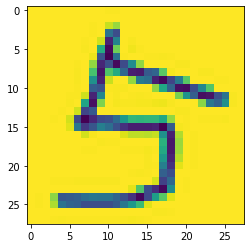

In [62]:
mnist_predict("5.png", model)

In [73]:
# 以下模型来自paddle案例，也是两层卷积各20没有FC，直接对接到softmax上（？）
def MnistConvModel2(input_shape):
    model = Sequential()
    model.add(Conv2D(20, kernel_size=5, activation='relu',padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Conv2D(20, kernel_size=5, activation='relu',padding='same',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    
    #   model = Sequential()
    #odel.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
    #odel.add(Conv2D(64, (3, 3), activation='relu'))
    #odel.add(MaxPooling2D(pool_size=(2, 2)))
    #odel.add(Dropout(0.25))
    #odel.add(Flatten())
    #odel.add(Dense(128, activation='relu'))
    #odel.add(Dropout(0.5))
    #odel.add(Dense(num_classes, activation='softmax'))
    #odel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    
    model.summary()
    return model

In [74]:
model2= MnistConvModel2(input_shape)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 20)        10020     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 980)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                9810      
Total params: 20,350
Trainable params: 20,350
Non-trainable params: 0
__________________________________________________

In [75]:
model2.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2545 - acc: 0.9208
Epoch 2/12
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0698 - acc: 0.9783
Epoch 3/12
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0511 - acc: 0.9840
Epoch 4/12
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0427 - acc: 0.9868
Epoch 5/12
60000/60000 [==============================] - 66s 1ms/step - loss: 0.0356 - acc: 0.9890
Epoch 6/12
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0311 - acc: 0.9904
Epoch 7/12
60000/60000 [==============================] - 57s 951us/step - loss: 0.0276 - acc: 0.9915
Epoch 8/12
60000/60000 [==============================] - 58s 974us/step - loss: 0.0249 - acc: 0.9922
Epoch 9/12
60000/60000 [==============================] - 59s 987us/step - loss: 0.0226 - acc: 0.9925
Epoch 10/12
60000/60000 [==============================] - 59s 989us/step - loss: 0.0201 - acc

In [76]:
score=model2.evaluate(x_test,y_test)
print("test score",score[0])
print("test accuracy",score[1])

10000/10000 [==============================] - 6s 561us/step
test score 0.02727453461117475
test accuracy 0.9904


本次预测的数字是:  5


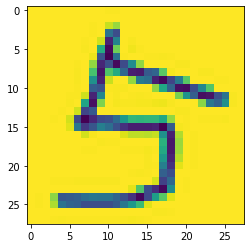

In [77]:
mnist_predict("5.png", model2)